In [1]:
import numpy as np 
import xarray as xr 
from scipy import optimize
from functools import reduce
import matplotlib.pyplot as plt 
import scipy.interpolate as interpolate

class AirTemp:
    
    def __init__(self, T_obs): 
        
        if T_obs.size in [365, 366]: 
            self.T_obs = T_obs
            self.doy   = np.arange(1,T_obs.size+1)
        else: 
            raise ValueError('T_obs must be of size 365 or 366')
        
    def forward(self, p): 
        T = p[0] * np.cos(2 * np.pi * (self.doy - int(p[1])) / self.doy.size) + p[2] 
        return T

    def __cost(self, p): 
        return self.forward(p) - self.T_obs
    
    def fit(self, p0, loss='soft_l1'): 
        res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        return res_lsq
    
def subset_time(src, years): 
    return src.where(src.time.dt.year.isin(years), drop=True)

def adjust_to_zref(src, z_ref): 
    return src  + (z_ref - src.elevation ) * 6.5e-3

def compute_DOY_vals(src): 
    mean = src.groupby('time.dayofyear').mean()
    std  = src.groupby('time.dayofyear').std()
    return mean, std

In [2]:
# load the AWS Data
with xr.open_dataset('input_data/SouthGlacier_AirTemp.nc') as src: 
    sg_aws = src.Air_temp.load()
with xr.open_dataset('input_data/CanadaCreek_AirTemp.nc') as src: 
    cc_aws = src.Air_temp.load()
    
# load the KMR Data
kmr_fp = '../../input_data/mass_balance/Kaskawulsh_NetBalance.nc'
with xr.open_dataset(kmr_fp) as src: 
    # rename the Air_temp array to match AWS convention
    kmr_gwa = src.rename({'Temp-GWA': 'Air_temp'}).Air_temp.load()
    # add elevation coordinate to match AWS convention
    kmr_gwa.coords['elevation'] = src.Z.mean(skipna=True)
    # add site coordinate to match AWS convention
    kmr_gwa.coords['site'] = 'KMR Net Balance'

In [3]:
# reference elevation used for comparing AWS timeseries
z_ref = 2193

# Find the overlapping years between the AWS, so the means aren't biased
years = reduce(np.intersect1d, (sg_aws.time.dt.year, cc_aws.time.dt.year, kmr_gwa.time.dt.year))

# subset the arrays to only the overlappign years
sg_aws  = subset_time(sg_aws,  years)
cc_aws  = subset_time(cc_aws,  years)
kmr_gwa = subset_time(kmr_gwa, years)

# adjust the airtemp to ref elevation based on laspe rate
sg_aws  = adjust_to_zref(sg_aws,  z_ref)
cc_aws  = adjust_to_zref(cc_aws,  z_ref)
kmr_gwa = adjust_to_zref(kmr_gwa, z_ref)

In [4]:
sg_DOY_mean,  sg_DOY_std  = compute_DOY_vals(sg_aws)
cc_DOY_mean,  cc_DOY_std  = compute_DOY_vals(cc_aws)
kmr_DOY_mean, kmr_DOY_std = compute_DOY_vals(kmr_gwa)

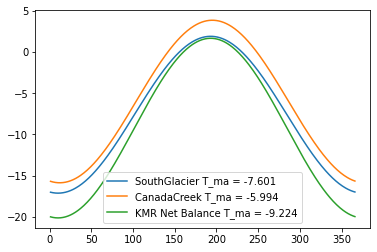

In [5]:


for airtemp in [sg_DOY_mean, cc_DOY_mean, kmr_DOY_mean]: 
    
    # initalize the model with observations
    Temp_model = AirTemp(airtemp)
    # fit the model with a first guess at the unknown params
    res_lstq   = Temp_model.fit(p0=[10,193,-8])
    # evaluate the forward model based on fitted param values
    predicted  = Temp_model.forward(res_lstq.x)
    
    T_ma = res_lstq.x[-1]
    plt.plot(Temp_model.doy, predicted, label=f"{airtemp.site.values} T_ma = {T_ma:.3f}")
    # plt.plot(airtemp.dayofyear, airtemp)
    
plt.legend()

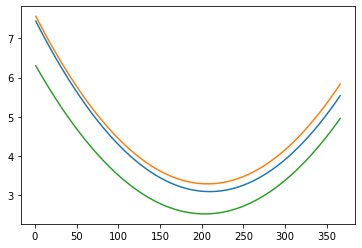

In [9]:
for tempstd in [sg_DOY_std, cc_DOY_std, kmr_DOY_std]: 
    
    p = np.polyfit(tempstd.dayofyear, tempstd, 2)

    plt.plot(tempstd.dayofyear, 
            np.polyval(p, tempstd.dayofyear),
            label='2nd Order Polynomial')


In [12]:
np.polyfit(sg_DOY_std.dayofyear, sg_DOY_std, 2)

array([ 9.98514451e-05, -4.18537660e-02,  7.48212135e+00])

In [10]:

# initalize the model with observations
Temp_model = AirTemp(sg_DOY_mean)
# fit the model with a first guess at the unknown params
res_lstq   = Temp_model.fit(p0=[10,193,-8])
# evaluate the forward model based on fitted param values
predicted  = Temp_model.forward(res_lstq.x)

res_lstq.x

array([  9.52339793, 193.        ,  -7.6006873 ])

In [13]:
def MassBalance_WFM2013(z, ELA=2550, dbdz=5.6e-3, b_min=-3.0, b_max=0.5):
    
    z_max = b_max/dbdz + ELA
    z_min = b_min/dbdz + ELA
    
    b = np.piecewise(z,
                    [z>=z_max, 
                     (z_max > z) & (z > z_min), 
                     z <= z_min],
                    [lambda z: b_max, 
                     lambda z: (z-ELA)*dbdz, 
                     lambda z: b_min])
    
    return b 
    

In [14]:
# Load the input numpy arrays
glc1a     = np.loadtxt("../../input_data/topography/glc1-a_surf.dat")
kmr_coefs = np.loadtxt("../../input_data/mass_balance/KMR_MB_k_2_s_2500_coefs.dat")
kmr_knots = np.loadtxt("../../input_data/mass_balance/KMR_MB_k_2_s_2500_knots.dat")

# split up the south glacier coordinate arrays
sg_x  = glc1a[:,0]
sg_z  = glc1a[:,1]

# pack up the knots and coefs into tck tuple
kmr_tck = (kmr_knots, kmr_coefs, 2)
# predict the mass balance from the kmr spline
kmr_mb  = interpolate.splev(sg_z, kmr_tck)

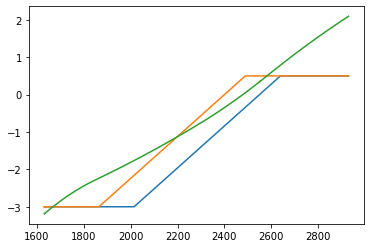

In [16]:
plt.plot(sg_z, MassBalance_WFM2013(sg_z))
plt.plot(sg_z, MassBalance_WFM2013(sg_z, ELA=2400))

plt.plot(sg_z, kmr_mb+-1.225)

In [ ]:
z_min